In [ ]:
#This notebook performs sentiment analysis on given mongodb-collection which contains the dialogue-data used in this study. 
#We used a multilingual sentiment classifier model for initial English and refined/expanded German dialogue texts.

In [7]:
import spacy
import torch
from transformers import AutoModel, AutoTokenizer
from scipy.spatial.distance import cosine
import json
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine


In [8]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.zeros(1).cuda())
print(torch.zeros(2).cuda())
print(torch.__path__)
print(torch.__version__)

True
2
NVIDIA RTX 4500 Ada Generation
tensor([0.], device='cuda:0')
tensor([0., 0.], device='cuda:0')
['/home/msd4/miniconda3/envs/eval_semantics/lib/python3.12/site-packages/torch']
2.3.1+cu121


# Sentiment Analysis

Number of expanded documents fetched: 99


/home/msd4/miniconda3/envs/eval_semantics/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Absolute Counts of Dominant Sentiments:
dominant_sentiment
negative    7646
positive    3112
neutral      659
Name: count, dtype: int64

Percentage of Dominant Sentiments:
dominant_sentiment
negative    67
positive    27
neutral      6
Name: count, dtype: int64


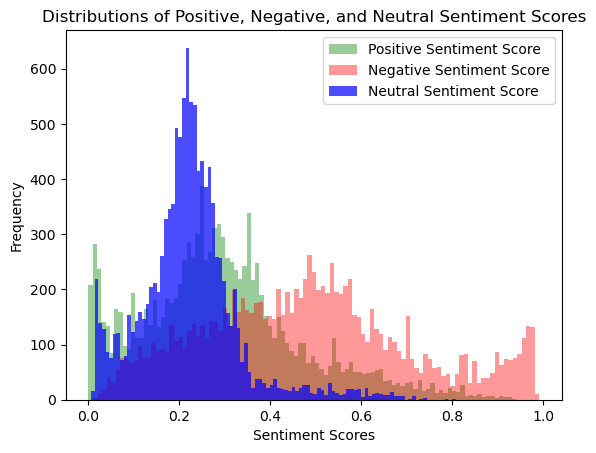

In [35]:
import re
import pandas as pd
from pymongo import MongoClient
from transformers import pipeline
import matplotlib.pyplot as plt

# Setup MongoDB client
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client['MIMIC-IV']
collection_expanded = db['NLP-EXPANDED-prammed-postprocessed_translation']

# Define the range to fetch documents
start_index_mongo = 0
range_size_mongo = 100

# Fetch documents from MongoDB
docs_expanded = list(collection_expanded.find().skip(start_index_mongo).limit(range_size_mongo))

print(f"Number of expanded documents fetched: {len(docs_expanded)}")

# Initialize the sentiment analysis pipeline
#device = -1  # Use CPU
device = "auto"  # Use CPU
distilled_student_sentiment_classifier = pipeline(
    "sentiment-analysis",
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    return_all_scores=True,
    device="cuda"
)

# Function to clean and split text into sentences
def clean_and_split_text(text):
    # Remove speaker prefixes like "EMT1:", "EMT2:", "Herr Smith:"
    cleaned_text = re.sub(r'\b\w+:\s*', '', text)
    
    # Remove leading and trailing whitespace and extra line breaks
    cleaned_text = cleaned_text.strip()
    
    # Remove quotes
    cleaned_text = re.sub(r'["“”]', '', cleaned_text)
    
    # Split the cleaned text into sentences using a regular expression
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s|(?<=\n)', cleaned_text)
    
    # Remove any leading/trailing whitespace from each sentence
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    
    return sentences

# Function to analyze sentiment of each document and create a DataFrame
def analyze_sentiment(documents, title, text):
    sentiment_data = []

    for document_index, document in enumerate(documents):
        dialogue = document.get(text, "")
        sentences = clean_and_split_text(dialogue)
        
        for sentence_index, sentence in enumerate(sentences):
            result = distilled_student_sentiment_classifier(sentence)[0]
            sentiment_scores = {
                "negative": result[0]['score'],
                "neutral": result[1]['score'],
                "positive": result[2]['score']
            }
            sentiment_data.append({
                "document_index": document_index,
                "sentence_index": sentence_index,
                "sentence": sentence,
                "negative": sentiment_scores["negative"],
                "neutral": sentiment_scores["neutral"],
                "positive": sentiment_scores["positive"]
            })

    # Create DataFrame from sentiment data
    df = pd.DataFrame(sentiment_data)

    return df


# Define whitch dialogue you want to analyse!!!!!
dialogue_text = 'dialogue'


# Analyze sentiment for expanded dialogues
df_dialogue = analyze_sentiment(docs_expanded, "Expanded Dialogues", dialogue_text)

# Determine the dominant sentiment for each sentence
df_dialogue['dominant_sentiment'] = df_dialogue[['negative', 'neutral', 'positive']].idxmax(axis=1)

# Count the occurrences of each dominant sentiment
sentiment_counts = df_dialogue['dominant_sentiment'].value_counts()

# Display the absolute counts
print("Absolute Counts of Dominant Sentiments:")
print(sentiment_counts)

# Calculate the total number of sentences
total_sentences = len(df_dialogue)

# Calculate the percentage for each sentiment and round them to whole numbers
sentiment_percentages = (sentiment_counts / total_sentences * 100).round().astype(int)

# Display the percentages
print("\nPercentage of Dominant Sentiments:")
print(sentiment_percentages)


# Plot the histograms for the sentiment scores
plt.hist(df_dialogue['positive'], bins=100, color='green', alpha=0.4, label='Positive Sentiment Score')
plt.hist(df_dialogue['negative'], bins=100, color='red', alpha=0.4, label='Negative Sentiment Score')
plt.hist(df_dialogue['neutral'], bins=100, color='blue', alpha=0.7, label='Neutral Sentiment Score')

# Naming the x & y axis
plt.xlabel('Sentiment Scores')
plt.ylabel('Frequency')

# Show a legend on the plot
plt.legend()

# Title of the plot
plt.title('Distributions of Positive, Negative, and Neutral Sentiment Scores')

# Save the result in the same folder
plt.savefig('original_sentiment_score_distributions.png')

# Show the plot
plt.show()
df_dialogue.to_csv('original_dialogues_sentiment.csv', index=False)

Number of expanded documents fetched: 99


/home/msd4/miniconda3/envs/eval_semantics/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Absolute Counts of Dominant Sentiments:
dominant_sentiment
negative    13350
positive     8500
neutral       625
Name: count, dtype: int64

Percentage of Dominant Sentiments:
dominant_sentiment
negative    59
positive    38
neutral      3
Name: count, dtype: int64


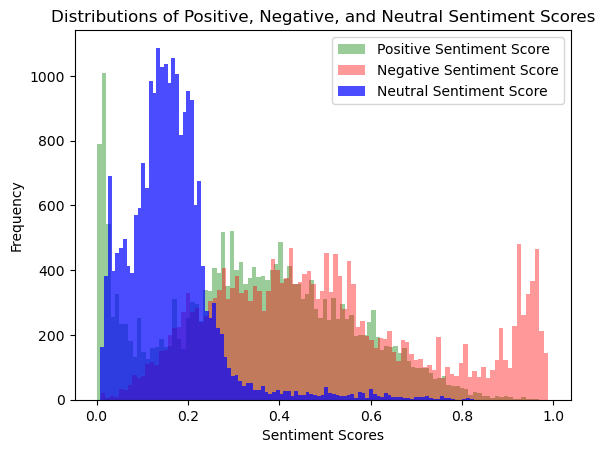

In [34]:
import re
import pandas as pd
from pymongo import MongoClient
from transformers import pipeline
import matplotlib.pyplot as plt

# Setup MongoDB client
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client['MIMIC-IV']
collection_expanded = db['NLP-EXPANDED-prammed-postprocessed_translation']

# Define the range to fetch documents
start_index_mongo = 0
range_size_mongo = 100

# Fetch documents from MongoDB
docs_expanded = list(collection_expanded.find().skip(start_index_mongo).limit(range_size_mongo))

print(f"Number of expanded documents fetched: {len(docs_expanded)}")

# Initialize the sentiment analysis pipeline
#device = -1  # Use CPU
device = "auto"  # Use CPU
distilled_student_sentiment_classifier = pipeline(
    "sentiment-analysis",
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    return_all_scores=True,
    device="cuda"
)

# Function to clean and split text into sentences
def clean_and_split_text(text):
    # Remove speaker prefixes like "EMT1:", "EMT2:", "Herr Smith:"
    cleaned_text = re.sub(r'\b\w+:\s*', '', text)
    
    # Remove leading and trailing whitespace and extra line breaks
    cleaned_text = cleaned_text.strip()
    
    # Remove quotes
    cleaned_text = re.sub(r'["“”]', '', cleaned_text)
    
    # Split the cleaned text into sentences using a regular expression
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s|(?<=\n)', cleaned_text)
    
    # Remove any leading/trailing whitespace from each sentence
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    
    return sentences

# Function to analyze sentiment of each document and create a DataFrame
def analyze_sentiment(documents, title, text):
    sentiment_data = []

    for document_index, document in enumerate(documents):
        dialogue = document.get(text, "")
        sentences = clean_and_split_text(dialogue)
        
        for sentence_index, sentence in enumerate(sentences):
            result = distilled_student_sentiment_classifier(sentence)[0]
            sentiment_scores = {
                "negative": result[0]['score'],
                "neutral": result[1]['score'],
                "positive": result[2]['score']
            }
            sentiment_data.append({
                "document_index": document_index,
                "sentence_index": sentence_index,
                "sentence": sentence,
                "negative": sentiment_scores["negative"],
                "neutral": sentiment_scores["neutral"],
                "positive": sentiment_scores["positive"]
            })

    # Create DataFrame from sentiment data
    df = pd.DataFrame(sentiment_data)

    return df


# Define whitch dialogue you want to analyse!!!!!
dialogue_text = 'final_dialogue'


# Analyze sentiment for expanded dialogues
df_dialogue = analyze_sentiment(docs_expanded, "Expanded Dialogues", dialogue_text)

# Determine the dominant sentiment for each sentence
df_dialogue['dominant_sentiment'] = df_dialogue[['negative', 'neutral', 'positive']].idxmax(axis=1)

# Count the occurrences of each dominant sentiment
sentiment_counts = df_dialogue['dominant_sentiment'].value_counts()

# Display the absolute counts
print("Absolute Counts of Dominant Sentiments:")
print(sentiment_counts)

# Calculate the total number of sentences
total_sentences = len(df_dialogue)

# Calculate the percentage for each sentiment and round them to whole numbers
sentiment_percentages = (sentiment_counts / total_sentences * 100).round().astype(int)

# Display the percentages
print("\nPercentage of Dominant Sentiments:")
print(sentiment_percentages)


# Plot the histograms for the sentiment scores
plt.hist(df_dialogue['positive'], bins=100, color='green', alpha=0.4, label='Positive Sentiment Score')
plt.hist(df_dialogue['negative'], bins=100, color='red', alpha=0.4, label='Negative Sentiment Score')
plt.hist(df_dialogue['neutral'], bins=100, color='blue', alpha=0.7, label='Neutral Sentiment Score')

# Naming the x & y axis
plt.xlabel('Sentiment Scores')
plt.ylabel('Frequency')

# Show a legend on the plot
plt.legend()

# Title of the plot
plt.title('Distributions of Positive, Negative, and Neutral Sentiment Scores')

# Save the result in the same folder
plt.savefig('original_sentiment_score_distributions.png')

# Show the plot
plt.show()
df_dialogue.to_csv('original_dialogues_sentiment.csv', index=False)
